# Final Project EDA
## FOMC Minutes Sentiment & Economic Indicators Analysis

Monetary policy communication plays a crucial role in shaping market expectations and macroeconomic outcomes. Among the Federal Reserve’s policy documents, the FOMC (Federal Open Market Committee) meeting minutes serve as a detailed record of economic deliberations and policy considerations. Released three weeks after each FOMC meeting, the minutes often contain nuanced insights into the Fed’s economic outlook and monetary stance that go beyond what is conveyed in the shorter, immediate post-meeting statements.

This project investigates the evolving sentiment in FOMC minutes and its relationship with key U.S. macroeconomic indicators. Leveraging natural language processing techniques—specifically, TF–IDF scoring constrained by domain-specific vocabularies—the textual content of each meeting’s minutes is transformed into a continuous sentiment index ranging from expansion to recession. This index serves as a proxy for the Fed’s policy tone and forward guidance.

To contextualize and analyze these sentiment dynamics, the project merges the FOMC sentiment data with a rich set of monthly economic indicators, including new manufacturing orders, consumer and producer price indices (CPI and PPI), oil prices, unemployment rates, and the Global Supply Chain Pressure Index (GSCPI). Each series is preprocessed for consistency, scaled appropriately, and aligned with the sentiment timeline to facilitate comparative and predictive analysis.

The final dataset contains fewer than 5 000 observations because it is deliberately constructed at a monthly cadence over a fixed historical window rather than at a higher-frequency or transaction-level granularity. Specifically, by aggregating all FOMC meeting sentiment into one value per calendar month and spanning approximately twenty‐five years (2000 – present), we produce on the order of 302 total rows. Merging additional economic indicators (each indexed by the same "YYYY/MM" period) augments the width of the table (columns) but does not increase its length (rows). This modest sample size is not only sufficient to capture medium‑term cyclical dynamics but also ensures efficient estimation, stable interpolation, and straightforward interpretation without the need for subsampling or excessive computational resources.

## Part 1: FOMC Data Ingestion and Reshaping

- **Data Source:** `communications.csv` containing all FOMC Statements and Minutes since 2000.
- **Goal:** Prepare a dataset with separate columns for each document type per FOMC date.
- **Key Steps:**
  - Load the CSV and inspect structure.
  - Filter for `Date`, `Type`, and `Text`.
  - Pivot into a wide format with one row per meeting date.
  - Fill in missing entries with empty strings.
  - Adjust the date (if the day is after the 27th) into the next month to better align with monthly economic data.
  - Remove duplicate `Date` entries.
  - Final format uses `"YYYY/MM"` strings.

In [1]:
# read communications.csv
import pandas as pd
df = pd.read_csv('communications.csv')

In [2]:
# see what the data looks like
df.head(10)

,Date,Release Date,Type,Text
0,2025-03-19,2025-04-09,Minute,Minutes of the Federal Open Market Committee\n...
1,2025-03-19,2025-03-19,Statement,Recent indicators suggest that economic activi...
2,2025-01-29,2025-01-29,Statement,Recent indicators suggest that economic activi...
3,2025-01-29,2025-02-19,Minute,Minutes of the Federal Open Market Committee\n...
4,2024-12-18,2024-12-18,Statement,Recent indicators suggest that economic activi...
5,2024-12-18,2025-01-08,Minute,Minutes of the Federal Open Market Committee\n...
6,2024-11-07,2024-11-26,Minute,Minutes of the Federal Open Market Committee\n...
7,2024-11-07,2024-11-07,Statement,Recent indicators suggest that economic activi...
8,2024-09-18,2024-09-18,Statement,Recent indicators suggest that economic activi...
9,2024-09-18,2024-10-09,Minute,Minutes of the Federal Open Market Committee\n...


In [3]:
# Extract the type needed
df_subset = df[['Date','Type','Text']].copy()

# Pivot so that we have one row per date
df_wide = (
    df_subset
    .pivot(index='Date', columns='Type', values='Text')
    .reset_index()
    .rename(columns={
        'Minute':    'minute_text',
        'Statement': 'statement_text'
    })
)

# Fill in the blanks
df_wide['minute_text']    = df_wide['minute_text'].fillna('')
df_wide['statement_text'] = df_wide['statement_text'].fillna('')

df = df_wide.copy()

# inspect the data
df.head(10)

Type,Date,minute_text,statement_text
0,2000-02-02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...
1,2000-03-21,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...
2,2000-05-16,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...
3,2000-06-28,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
4,2000-08-22,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
5,2000-10-03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
6,2000-11-15,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
7,2000-12-19,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...
8,2001-01-03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee decided toda...
9,2001-01-31,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...


In [4]:
# make sure it’s a proper datetime
df["Date"] = pd.to_datetime(df["Date"])

# shift any date where day > 20 into the next month
df["Date_adj"] = df["Date"].apply(
    lambda dt: dt + pd.DateOffset(months=1) if dt.day > 27 else dt
)

# now re‑format to "YYYY/MM"
df["Date"] = df["Date_adj"].dt.strftime("%Y/%m")

# clean up
df1 = df.drop(columns=["Date_adj"])

# quick check
print(df["Date"].head(10))

0    2000/02
1    2000/03
2    2000/05
3    2000/07
4    2000/08
5    2000/10
6    2000/11
7    2000/12
8    2001/01
9    2001/02
Name: Date, dtype: object


In [5]:
duplicates = df.duplicated(subset=['Date'])
# remove the duplicates in the date column
df = df[~duplicates]
# check again
duplicates = df.duplicated(subset=['Date'])
duplicates_count = duplicates.sum()
print(f"Number of duplicates in the date column after removal: {duplicates_count}")
# check the shape of the dataframe
df.shape

Number of duplicates in the date column after removal: 0


(213, 4)

## Part 2: Sentiment Construction via TF–IDF

### Vocabulary Curation (Using WordNet)
- **Two thematic categories:**  
  - **Expansion** (e.g., growth, rebound, hiring)  
  - **Recession**  (e.g., slump, unemployment, panic)  
- **Approach:**  
  1. Expand ~30 seed words into ~250 keywords using WordNet synonyms.  
  2. Build category vocabularies for **expansion** and **recession**.  
  3. Combine them into a dictionary `econ_vocab`.  

### TF–IDF Computation
- Tokenize FOMC texts (`minute_text` & `statement_text`) using NLTK.  
- Build a `TfidfVectorizer` restricted to the custom economic vocabulary.  
- Transform both text columns into sparse TF–IDF matrices.  
- **For each document:**  
  1. Sum TF–IDF scores separately for expansion and recession terms.  
  2. Normalize to a score in **[-1, 1]**:

```math
  \text{score} = \frac{\text{expansion} - \text{recession}}{\text{expansion} + \text{recession}}
```

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('omw-1.4')

def expand_terms(seeds, target_size):
    """
    Expand a list of seed terms using WordNet.
    Args:
        seeds (list): List of seed terms.
        target_size (int): Desired size of the expanded list.
    Returns:
        list: Expanded list of terms.
    """
    terms = set(seeds)
    for seed in seeds:
        for syn in wn.synsets(seed):
            for lemma in syn.lemmas():
                name = lemma.name().lower()
                # drop multi‑word entries and non‑alpha
                if name.isalpha():
                    terms.add(name)
                if len(terms) >= target_size:
                    break
            if len(terms) >= target_size:
                break
        if len(terms) >= target_size:
            break
    return list(terms)[:target_size]

# Core seeds for each side
expansion_seeds = [
    "growth","expansion","recovery","boom","surge","rebound","acceleration",
    "hiring","jobs","employment","investment","credit","demand","confidence",
    "rally","optimism","stimulus","easing","export","inflation","sales","profit",
    "income","wealth","spending","production"
]

recession_seeds = [
    "contraction","downturn","slump","bust","slowdown","decline","dip","crash",
    "plummet","layoff","unemployment","default","bankruptcy","deflation",
    "disinflation","panic","volatility","tightening","austerity","retrenchment",
    "bear","pessimism","risk","debt","bailout","crisis"
]

# Expand the terms
expansion_terms = expand_terms(expansion_seeds, 250)
recession_terms  = expand_terms(recession_seeds, 250)

# Build your final vocab dict
econ_vocab = {
    "expansion": expansion_terms,
    "recession": recession_terms
}

# Verify sizes
print("Expansion:", len(econ_vocab["expansion"]))
print("Recession:", len(econ_vocab["recession"]))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/paulwang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Expansion: 180
Recession: 138


In [7]:
# Prepare your expansion/recession sets
exp_set = set(econ_vocab["expansion"])
rec_set = set(econ_vocab["recession"])
all_terms = list(exp_set | rec_set)

# Build a TF–IDF vectorizer that only considers the econ terms
tfidf = TfidfVectorizer(
    vocabulary=all_terms,
    tokenizer=nltk.word_tokenize,
    lowercase=True,
    token_pattern=None  # because we’re passing our own tokenizer
)

# Fit‑transform corpus of minutes
corpus_minute = df["minute_text"].astype(str).tolist()
X1 = tfidf.fit_transform(corpus_minute)
corput_statement = df["statement_text"].astype(str).tolist()
X2 = tfidf.transform(corput_statement)

# Identify column indices for each category
feat_names = tfidf.get_feature_names_out()
exp_idx = [i for i,w in enumerate(feat_names) if w in exp_set]
rec_idx = [i for i,w in enumerate(feat_names) if w in rec_set]

# Compute per‑doc TF–IDF sums
exp_tfidf1 = X1[:, exp_idx].sum(axis=1).A1   # sum of expansion weights
rec_tfidf1 = X1[:, rec_idx].sum(axis=1).A1   # sum of recession  weights
exp_tfidf2 = X2[:, exp_idx].sum(axis=1).A1   # sum of expansion weights
rec_tfidf2 = X2[:, rec_idx].sum(axis=1).A1   # sum of recession  weights

# Normalize into a [-1,1] score
denom1 = exp_tfidf1 + rec_tfidf1
denom2 = exp_tfidf2 + rec_tfidf2

# avoid division by zero
sent_tfidf1 = np.where(denom1>0, (exp_tfidf1 - rec_tfidf1) / denom1, 0.0)
sent_tfidf2 = np.where(denom2>0, (exp_tfidf2 - rec_tfidf2) / denom2, 0.0)

# Attach back to the DataFrame
df["score_minute"] = sent_tfidf1
df["score_statement"] = sent_tfidf2

# check the data
df.head(10)

/var/folders/9v/swhhkcgn3h543bcvl6qz76lc0000gn/T/ipykernel_25038/1176048621.py:37: RuntimeWarning: invalid value encountered in divide
  sent_tfidf2 = np.where(denom2>0, (exp_tfidf2 - rec_tfidf2) / denom2, 0.0)


Type,Date,minute_text,statement_text,Date_adj,score_minute,score_statement
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,2000-02-02,0.510585,1.000000
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,2000-03-21,0.656842,1.000000
2,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,2000-05-16,0.625849,0.751763
3,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-07-28,0.641479,0.804554
4,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-08-22,0.755590,0.391951
5,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-10-03,0.698118,0.184746
6,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-11-15,0.676635,0.714945
7,2000/12,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2000-12-19,0.752523,0.823696
8,2001/01,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee decided toda...,2001-01-03,0.752523,1.000000
9,2001/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,2001-02-28,0.533044,0.568415


## Part 3: Time Series Preparation

### Monthly Interpolation
- Convert `Date` column to a **PeriodIndex** (monthly).  
- Reindex to include **all months** between the first and last.  
- Interpolate sentiment scores (`score_minute`, `score_statement`) linearly.  
- Forward‑ and backward‑fill edge cases.  
- Normalize the interpolated scores to **[0, 1]** with `MinMaxScaler`.  

### Distribution Plots
- Plot sentiment distributions for **minute** and **statement** documents to visually inspect variation.  

In [8]:
# Convert the Date column to a PeriodIndex at month‐end
df['Period'] = pd.to_datetime(df['Date'], format='%Y/%m').dt.to_period('M')

# Create a new DataFrame with the period as the index
all_months = pd.period_range(df['Period'].min(), df['Period'].max(), freq='M')
df_full   = df.set_index('Period').reindex(all_months)

# Fill in the gaps
df_full['score_minute'] = df_full['score_minute'].astype(float)
df_full['score_statement'] = df_full['score_statement'].astype(float)

# Perform linear interpolation on the score
df_full['score_interp_minute'] = df_full['score_minute'].interpolate(method='linear')
df_full['score_interp_statement'] = df_full['score_statement'].interpolate(method='linear')

# fill forward and backward
df_full['score_interp_minute'] = df_full['score_interp_minute'].ffill().bfill()
df_full['score_interp_statement'] = df_full['score_interp_statement'].ffill().bfill()

# Restore 'Date' as a YYYY/MM string for plotting/merging
df_full['Date'] = df_full.index.to_timestamp().strftime('%Y/%m')
df = df_full.reset_index(drop=True)

# Inspect the filled series
df[['Date','score_interp_minute', 'score_interp_statement']].head(10)

Type,Date,score_interp_minute,score_interp_statement
0,2000/02,0.510585,1.000000
1,2000/03,0.656842,1.000000
2,2000/04,0.641346,0.875882
3,2000/05,0.625849,0.751763
4,2000/06,0.633664,0.778159
5,2000/07,0.641479,0.804554
6,2000/08,0.755590,0.391951
7,2000/09,0.726854,0.288349
8,2000/10,0.698118,0.184746
9,2000/11,0.676635,0.714945


In [9]:
from sklearn.preprocessing import MinMaxScaler
sent = df[["score_interp_minute"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
df["score_minute"] = scaler.fit_transform(sent)

# drop the column score, score_interp, and Date_adj
df = df.drop(columns=["score_interp_minute", "Date_adj"])

# see the data
df.head(10)

Type,Date,minute_text,statement_text,score_minute,score_statement,score_interp_statement
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000,1.000000
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000,1.000000
2,2000/04,NaN,NaN,0.772549,NaN,0.875882
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.751763,0.751763
4,2000/06,NaN,NaN,0.757256,NaN,0.778159
5,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.772815,0.804554,0.804554
6,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,1.000000,0.391951,0.391951
7,2000/09,NaN,NaN,0.942789,NaN,0.288349
8,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.885578,0.184746,0.184746
9,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.842807,0.714945,0.714945


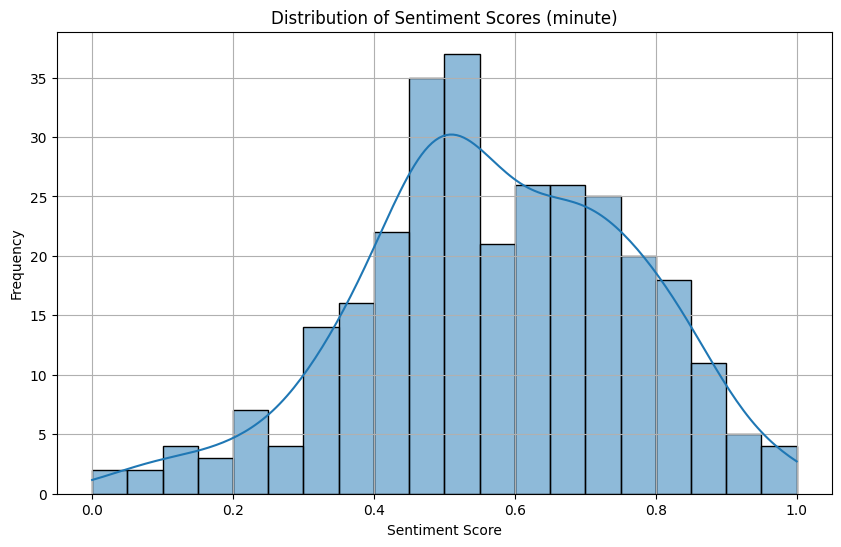

In [10]:
# plot the distribution of scores
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['score_minute'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores (minute)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [11]:
sent = df[["score_interp_statement"]].values
scaler = MinMaxScaler(feature_range=(0, 1))
df["score_statement"] = scaler.fit_transform(sent)

# drop the column score, score_interp, and Date_adj
df = df.drop(columns=["score_interp_statement"])

# see the data
df.head(10)

Type,Date,minute_text,statement_text,score_minute,score_statement
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000
2,2000/04,NaN,NaN,0.772549,0.919276
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.838552
4,2000/06,NaN,NaN,0.757256,0.855719
5,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.772815,0.872886
6,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,1.000000,0.604537
7,2000/09,NaN,NaN,0.942789,0.537156
8,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.885578,0.469775
9,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.842807,0.814606


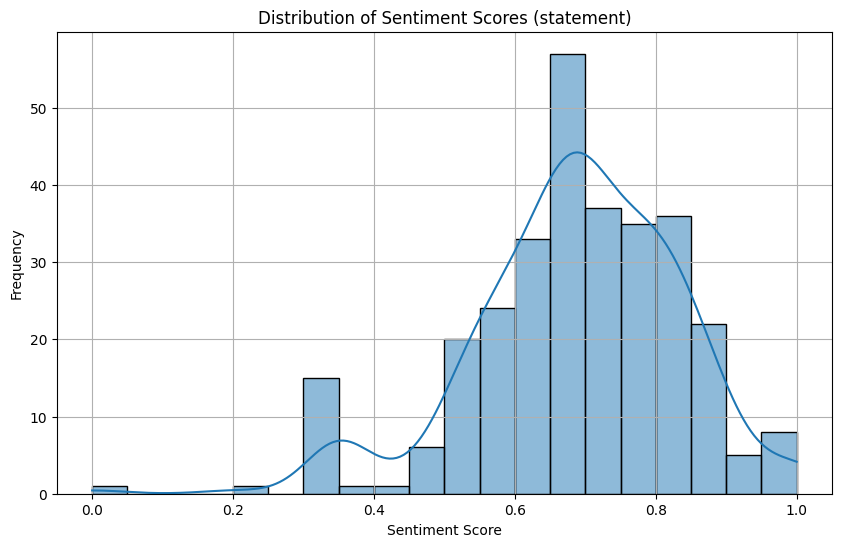

In [12]:
# plot the distribution of sentiment scores for statement
plt.figure(figsize=(10, 6))
sns.histplot(df['score_statement'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores (statement)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Part 4: Merging Economic Indicators

**Preprocessing steps for each series:**

1. Load from FRED or external CSV.  
2. Rename date and value columns.  
3. Format date to `"YYYY/MM"` for consistent merging.  
4. Handle missing values.  
5. Normalize with `MinMaxScaler`.  

| Indicator Name               | File                        | Notes                                               |
|------------------------------|-----------------------------|-----------------------------------------------------|
| New Orders (Mfg)             | `AMTMNO.csv`                | Box–Cox transform + min‑max scaling                 |
| Sticky CPI                   | `STICKCPIM157SFRBATL.csv`   | Core inflation measure with persistence             |
| PPI                          | `PCUOMFGOMFG.csv`           | Producer Price Index (manufacturing)                |
| Oil Prices                   | `WTISPLC.csv`               | WTI spot prices                                     |
| Unemployment Rate            | `UNRATE.csv`                | Civilian unemployment rate                          |
| Supply Chain Index           | `gscpi_data.csv`            | Global Supply Chain Pressure Index (NY Fed)         |
| Industrial Production Index  | `INDRPO.csv`                | Industrial capacity index                           |

Each indicator is visualized with a **histogram + KDE** to inspect post‑normalization distribution.

In [13]:
new_orders = pd.read_csv('AMTMNO.csv')
# see the data
print(new_orders.head)

<bound method NDFrame.head of     observation_date  AMTMNO
0         2000-01-01  350725
1         2000-02-01  331991
2         2000-03-01  344182
3         2000-04-01  347917
4         2000-05-01  340085
..               ...     ...
297       2024-10-01  588231
298       2024-11-01  583689
299       2024-12-01  580160
300       2025-01-01  590391
301       2025-02-01  593956

[302 rows x 2 columns]>


In [14]:
# rename the column "observation_date" to "Date", "AMTMNO" to "new_orders_manufacturing"
new_orders = new_orders.rename(columns={"observation_date": "Date"})
new_orders = new_orders.rename(columns={"AMTMNO": "new_orders_manufacturing"})
# change the date format to YYYY/MM
new_orders["Date"] = pd.to_datetime(new_orders["Date"])
new_orders["Date"] = new_orders["Date"].dt.strftime("%Y/%m")
# see the data
print(new_orders.head())

      Date  new_orders_manufacturing
0  2000/01                    350725
1  2000/02                    331991
2  2000/03                    344182
3  2000/04                    347917
4  2000/05                    340085


In [15]:
# If the date matches the date in df, then add the new orders to the df
df = df.merge(new_orders, on="Date", how="left")
# see the data
print(df.head())

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing  
0         1.000000                  331991.0  
1         1.000000                  344182.0  
2         0.919276                  347917.0  


In [16]:
# for the new orders, if the value is NaN, then drop the row
df = df.dropna(subset=["new_orders_manufacturing"])

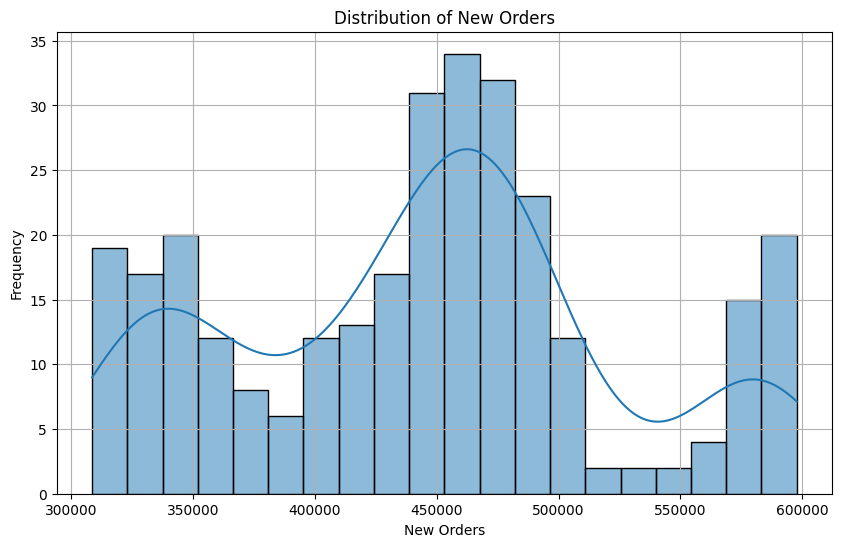

In [17]:
# plot the distribution of new orders
plt.figure(figsize=(10, 6))
sns.histplot(df['new_orders_manufacturing'], bins=20, kde=True)
plt.title('Distribution of New Orders')
plt.xlabel('New Orders')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Here I chose a PowerTransformer (Box–Cox) on the New Orders series because:

- **Strong skew & heteroskedasticity**

    Monthly manufacturing new orders have a long right tail and non‐constant variance. Box–Cox finds an optimal power‐transform lambda to pull in that tail and stabilize variance.

- **Approximate normality**

    Many downstream methods (e.g. interpolation, correlation analysis, regressions, PCA) perform better when inputs are roughly Gaussian. The PowerTransformer helps satisfy that.

- **Positive‐only data**

    Box–Cox requires strictly positive values—which New Orders has—so it’s a natural fit.

- **Improved scaling**

    After variance stabilization, the subsequent MinMaxScaler spreads values more evenly over [0, 1], avoiding overly compressed regions in the distribution.

In [18]:
from sklearn.preprocessing import PowerTransformer

# extract as ndarray once
series = df["new_orders_manufacturing"].values

pt_boxcox = PowerTransformer(method="box-cox", standardize=False)
transformed = pt_boxcox.fit_transform(series.reshape(-1, 1))

df["new_orders_manufacturing"] = transformed.flatten()

scaler = MinMaxScaler(feature_range=(0, 1))
df["new_orders_manufacturing"] = scaler.fit_transform(df[["new_orders_manufacturing"]])

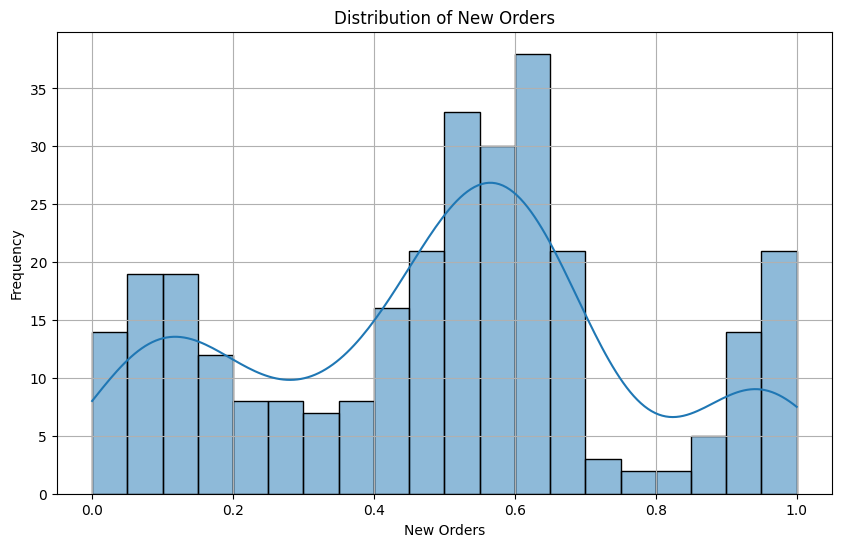

In [19]:
# plot the distribution of new orders
plt.figure(figsize=(10, 6))
sns.histplot(df['new_orders_manufacturing'], bins=20, kde=True)
plt.title('Distribution of New Orders')
plt.xlabel('New Orders')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [20]:
# see the data
print(df.head())

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing  
0         1.000000                  0.092082  
1         1.000000                  0.139070  
2         0.919276                  0.153331  


In [21]:
CPI = pd.read_csv('STICKCPIM157SFRBATL.csv')
# see the data
print(CPI.head())

  observation_date  STICKCPIM157SFRBATL
0       2000-01-01              0.35406
1       2000-02-01              0.17475
2       2000-03-01              0.26939
3       2000-04-01              0.13823
4       2000-05-01              0.26353


In [22]:
# rename the column "observation_date" to "Date", "STICKCPIM157SFRBATL" to "CPI"
CPI = CPI.rename(columns={"observation_date": "Date"})
CPI = CPI.rename(columns={"STICKCPIM157SFRBATL": "CPI"})
# change the date format to YYYY/MM
CPI["Date"] = pd.to_datetime(CPI["Date"])
CPI["Date"] = CPI["Date"].dt.strftime("%Y/%m")
# merge the CPI data with the df
df = df.merge(CPI, on="Date", how="left")
# see the data
print(df.head())

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing      CPI  
0         1.000000                  0.092082  0.17475  
1         1.000000                  0.139070  0.26939  
2         0.919276  

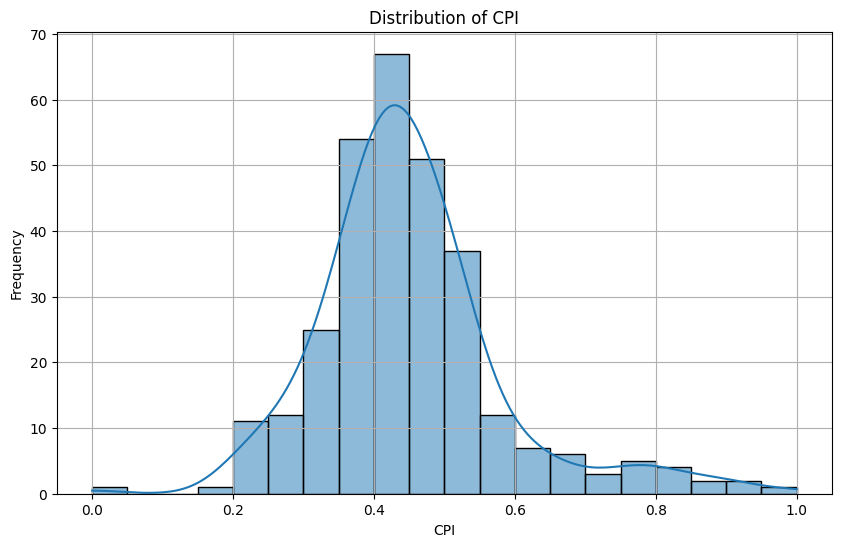

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI  
0         1.000000                  0.092082  0.391260  
1         1.000000                  0.139070  0.506174  
2         0.91927

In [23]:
# for the CPI, if the value is NaN, then drop the row
df = df.dropna(subset=["CPI"])
# use minmax scaler to scale the CPI data
scaler = MinMaxScaler(feature_range=(0, 1))
df["CPI"] = scaler.fit_transform(df[["CPI"]])
# plot the distribution of CPI
plt.figure(figsize=(10, 6))
sns.histplot(df['CPI'], bins=20, kde=True)
plt.title('Distribution of CPI')
plt.xlabel('CPI')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

In [24]:
ppi = pd.read_csv('PCUOMFGOMFG.csv')
# see the data
print(ppi.head())

  observation_date  PCUOMFGOMFG
0       2000-01-01        130.8
1       2000-02-01        132.2
2       2000-03-01        132.9
3       2000-04-01        132.6
4       2000-05-01        133.1


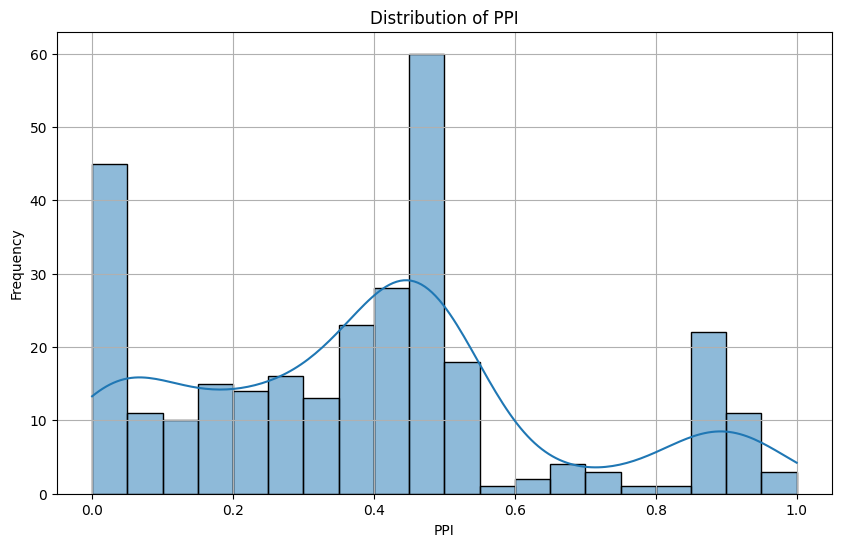

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  
0         1.000000                  0.092082  0.391260  0.004587  
1         1.000000                  0.139070  0.506174

In [25]:
# rename the column "observation_date" to "Date", "PCUOMFGOMFG" to "PPI"
ppi = ppi.rename(columns={"observation_date": "Date"})
ppi = ppi.rename(columns={"PCUOMFGOMFG": "PPI"})
# change the date format to YYYY/MM
ppi["Date"] = pd.to_datetime(ppi["Date"])
ppi["Date"] = ppi["Date"].dt.strftime("%Y/%m")
# merge the PPI data with the df
df = df.merge(ppi, on="Date", how="left")
# use minmax scaler to scale the PPI data
scaler = MinMaxScaler(feature_range=(0, 1))
df["PPI"] = scaler.fit_transform(df[["PPI"]])
# plot the distribution of PPI
plt.figure(figsize=(10, 6))
sns.histplot(df['PPI'], bins=20, kde=True)
plt.title('Distribution of PPI')
plt.xlabel('PPI')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

In [26]:
oil_prices = pd.read_csv('WTISPLC.csv')
# see the data
print(oil_prices.head())

  observation_date  WTISPLC
0       2000-01-01    27.18
1       2000-02-01    29.35
2       2000-03-01    29.89
3       2000-04-01    25.74
4       2000-05-01    28.78


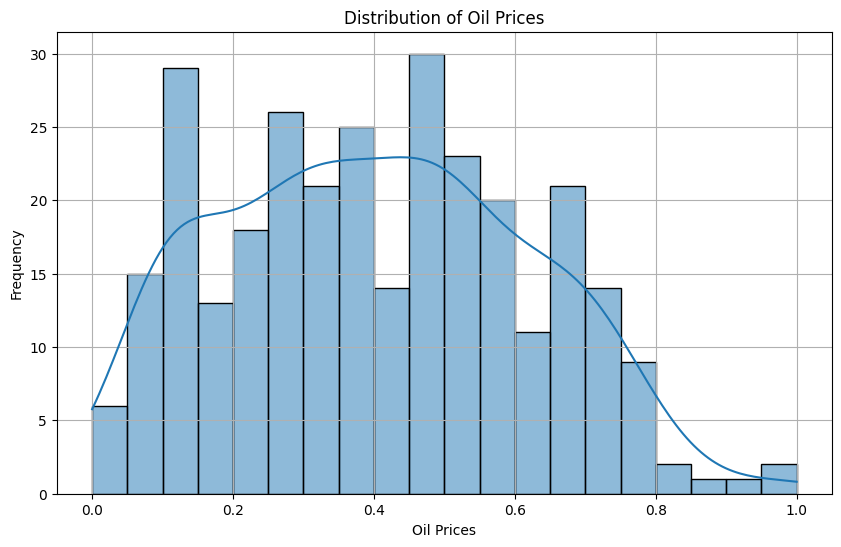

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  oil_prices  
0         1.000000                  0.092082  0.391260  0.004587    0.109048  
1         1.000000            

In [27]:
# rename the column "observation_date" to "Date", "WTISPLC" to "oil_prices"
oil_prices = oil_prices.rename(columns={"observation_date": "Date"})
oil_prices = oil_prices.rename(columns={"WTISPLC": "oil_prices"})
# change the date format to YYYY/MM
oil_prices["Date"] = pd.to_datetime(oil_prices["Date"])
oil_prices["Date"] = oil_prices["Date"].dt.strftime("%Y/%m")
# merge the oil prices data with the df
df = df.merge(oil_prices, on="Date", how="left")
# use minmax scaler to scale the oil prices data
scaler = MinMaxScaler(feature_range=(0, 1))
df["oil_prices"] = scaler.fit_transform(df[["oil_prices"]])
# plot the distribution of oil prices
plt.figure(figsize=(10, 6))
sns.histplot(df['oil_prices'], bins=20, kde=True)
plt.title('Distribution of Oil Prices')
plt.xlabel('Oil Prices')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

In [28]:
unemployment = pd.read_csv('UNRATE.csv')
# see the data
print(unemployment.head())

  observation_date  UNRATE
0       2000-01-01     4.0
1       2000-02-01     4.1
2       2000-03-01     4.0
3       2000-04-01     3.8
4       2000-05-01     4.0


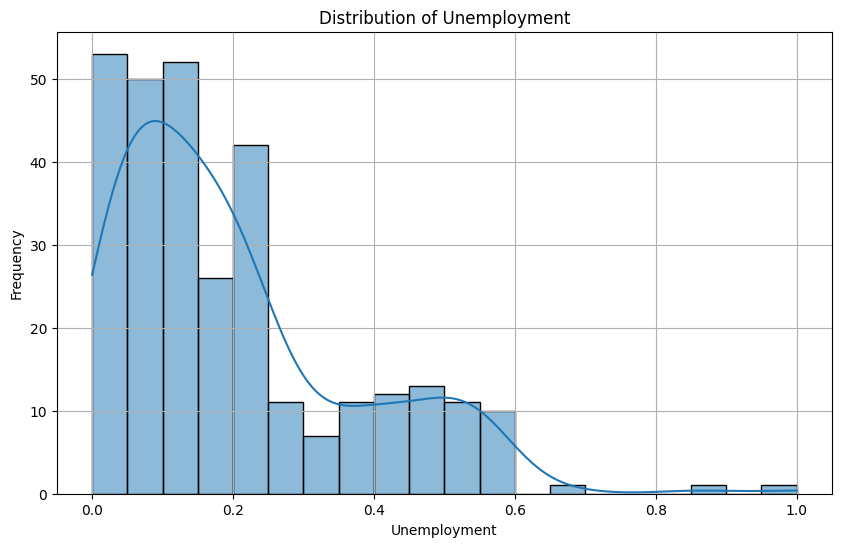

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  oil_prices  \
0         1.000000                  0.092082  0.391260  0.004587    0.109048   
1         1.000000          

In [29]:
# rename the column "observation_date" to "Date", "UNRATE" to "unemployment"
unemployment = unemployment.rename(columns={"observation_date": "Date"})
unemployment = unemployment.rename(columns={"UNRATE": "unemployment"})
# change the date format to YYYY/MM
unemployment["Date"] = pd.to_datetime(unemployment["Date"])
unemployment["Date"] = unemployment["Date"].dt.strftime("%Y/%m")
# merge the unemployment data with the df
df = df.merge(unemployment, on="Date", how="left")
# use minmax scaler to scale the unemployment data
scaler = MinMaxScaler(feature_range=(0, 1))
df["unemployment"] = scaler.fit_transform(df[["unemployment"]])
# plot the distribution of unemployment
plt.figure(figsize=(10, 6))
sns.histplot(df['unemployment'], bins=20, kde=True)
plt.title('Distribution of Unemployment')
plt.xlabel('Unemployment')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())


In [30]:
GSCPI = pd.read_csv('gscpi_data.csv')
# see the data
print(GSCPI.head())

          Date  GSCPI  Unnamed: 2                           Unnamed: 3  \
0          NaN    NaN         NaN      NEW YORK FED  ECONOMIC RESEARCH   
1          NaN    NaN         NaN                                  NaN   
2          NaN    NaN         NaN  https://www.newyorkfed.org/research   
3          NaN    NaN         NaN                                  NaN   
4  31-Jan-1998  -1.08         NaN                                  NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   Unnamed: 10  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4      

In [31]:
# for the GSCPI, if the value is NaN, then drop the row
GSCPI = GSCPI.dropna(subset=["GSCPI"])
# rename the column "observation_date" to "Date", "GSCPI" to "GSCPI"
GSCPI = GSCPI.rename(columns={"observation_date": "Date"})
GSCPI = GSCPI.rename(columns={"GSCPI": "GSCPI"})
# change the date format to YYYY/MM
GSCPI["Date"] = pd.to_datetime(GSCPI["Date"])
GSCPI["Date"] = GSCPI["Date"].dt.strftime("%Y/%m")
# see the data
print(GSCPI.head())

      Date  GSCPI  Unnamed: 2 Unnamed: 3  Unnamed: 4  Unnamed: 5  Unnamed: 6  \
4  1998/01  -1.08         NaN        NaN         NaN         NaN         NaN   
5  1998/02  -0.45         NaN        NaN         NaN         NaN         NaN   
6  1998/03  -0.08         NaN        NaN         NaN         NaN         NaN   
7  1998/04  -0.14         NaN        NaN         NaN         NaN         NaN   
8  1998/05  -0.44         NaN        NaN         NaN         NaN         NaN   

   Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  
4         NaN         NaN         NaN          NaN  
5         NaN         NaN         NaN          NaN  
6         NaN         NaN         NaN          NaN  
7         NaN         NaN         NaN          NaN  
8         NaN         NaN         NaN          NaN  


In [32]:
# delete the columns "Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", 
# "Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"
GSCPI = GSCPI.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", 
                            "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", 
                            "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"])
# merge the GSCPI data with the df
df = df.merge(GSCPI, on="Date", how="left")


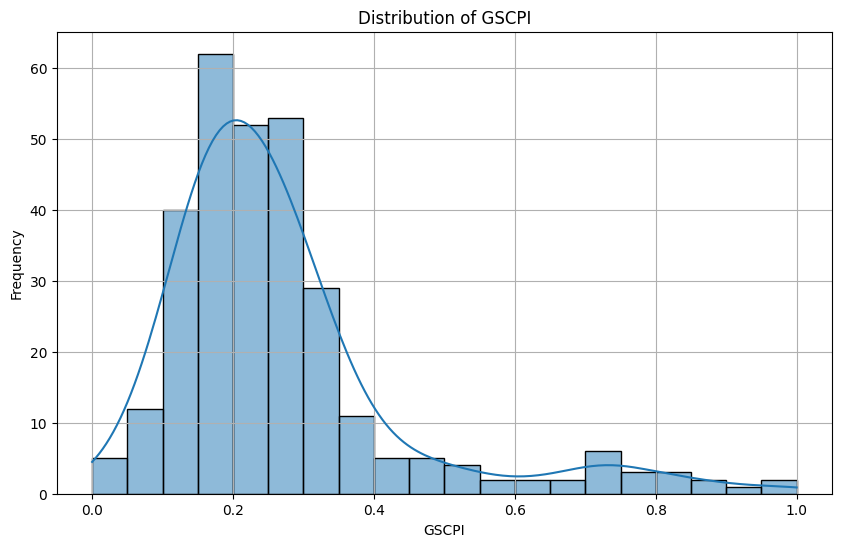

      Date                                        minute_text  \
0  2000/02  Minutes of the Federal Open Market Committee\n...   
1  2000/03  Minutes of the Federal Open Market Committee\n...   
2  2000/04                                                NaN   
3  2000/05  Minutes of the Federal Open Market Committee\n...   
4  2000/06                                                NaN   

                                      statement_text  score_minute  \
0  The Federal Open Market Committee voted today ...      0.512214   
1  The Federal Open Market Committee voted today ...      0.803401   
2                                                NaN      0.772549   
3  The Federal Open Market Committee voted today ...      0.741697   
4                                                NaN      0.757256   

   score_statement  new_orders_manufacturing       CPI       PPI  oil_prices  \
0         1.000000                  0.092082  0.391260  0.004587    0.109048   
1         1.000000          

In [33]:
# use minmax scaler to scale the GSCPI data
scaler = MinMaxScaler(feature_range=(0, 1))
df["GSCPI"] = scaler.fit_transform(df[["GSCPI"]])
# plot the distribution of GSCPI
plt.figure(figsize=(10, 6))
sns.histplot(df['GSCPI'], bins=20, kde=True)
plt.title('Distribution of GSCPI')
plt.xlabel('GSCPI')
plt.ylabel('Frequency')
plt.grid()
plt.show()
# see the data
print(df.head())

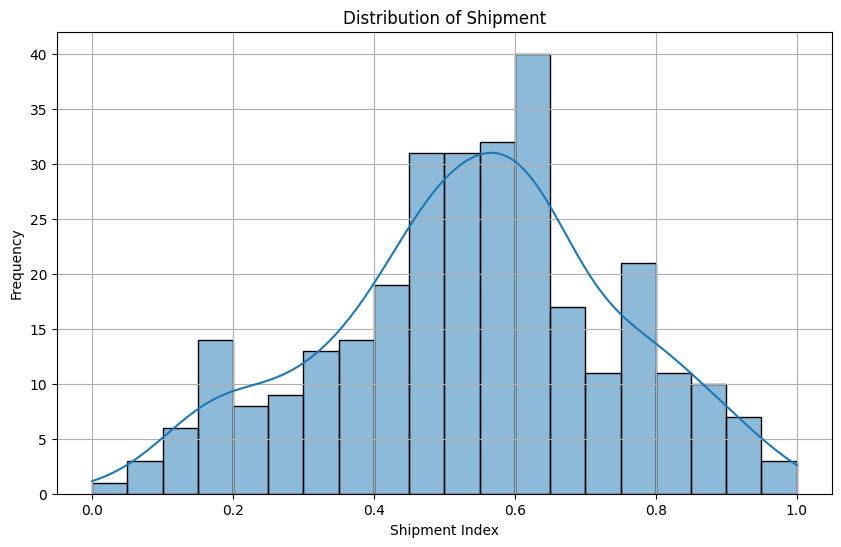

In [36]:
shipment_idx = pd.read_csv('FRGSHPUSM649NCIS.csv')
# rename the column "observation_date" to "Date", "INDPRO" to "shipment_idx"
shipment_idx = shipment_idx.rename(columns={"observation_date": "Date"})
shipment_idx = shipment_idx.rename(columns={"FRGSHPUSM649NCIS": "shipment_idx"})
# change the date format to YYYY/MM
shipment_idx["Date"] = pd.to_datetime(shipment_idx["Date"])
shipment_idx["Date"] = shipment_idx["Date"].dt.strftime("%Y/%m")
# merge the shipment_idx data with the df
df = df.merge(shipment_idx, on="Date", how="left")
# use minmax scaler to scale the shipment_idx data
scaler = MinMaxScaler(feature_range=(0, 1))
df["shipment_idx"] = scaler.fit_transform(df[["shipment_idx"]])
# plot the distribution of shipment_idx
plt.figure(figsize=(10, 6))
sns.histplot(df['shipment_idx'], bins=20, kde=True)
plt.title('Distribution of Shipment')
plt.xlabel('Shipment Index')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Final Output

A single DataFrame `df` indexed by monthly periods (`YYYY/MM`), combining:

- **TF–IDF–derived** sentiment scores from minutes and statements  
- **Interpolated** sentiment scores for months with no meetings  
- **Scaled** economic indicators across manufacturing, inflation, labor, and supply‑chain dimensions  

This clean, merged dataset is ready for downstream **correlation analysis**, **time series modeling**, or **causal inference**.

In [38]:
df.head(10)

,Date,minute_text,statement_text,score_minute,score_statement,new_orders_manufacturing,CPI,PPI,oil_prices,unemployment,GSCPI,shipment_idx_x,shipment_idx_y,shipment_idx
0,2000/02,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.512214,1.000000,0.092082,0.391260,0.004587,0.109048,0.061404,0.193656,1.112,1.112,0.526210
1,2000/03,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.803401,1.000000,0.139070,0.506174,0.009937,0.113648,0.052632,0.213689,1.142,1.142,0.586694
2,2000/04,NaN,NaN,0.772549,0.919276,0.153331,0.346916,0.007644,0.078293,0.035088,0.283806,1.102,1.102,0.506048
3,2000/05,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee voted today ...,0.741697,0.838552,0.123355,0.499059,0.011466,0.104192,0.052632,0.308848,1.103,1.103,0.508065
4,2000/06,NaN,NaN,0.757256,0.855719,0.253843,0.473815,0.019875,0.130175,0.052632,0.268781,1.141,1.141,0.584677
5,2000/07,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.772815,0.872886,0.135888,0.495550,0.017582,0.112626,0.052632,0.260434,1.052,1.052,0.405242
6,2000/08,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,1.000000,0.604537,0.125826,0.539456,0.014524,0.124979,0.061404,0.275459,1.157,1.157,0.616935
7,2000/09,NaN,NaN,0.942789,0.537156,0.178532,0.389244,0.023697,0.147640,0.043860,0.268781,1.183,1.183,0.669355
8,2000/10,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.885578,0.469775,0.121528,0.442889,0.025226,0.140825,0.043860,0.176962,1.160,1.160,0.622984
9,2000/11,Minutes of the Federal Open Market Committee\n...,The Federal Open Market Committee at its meeti...,0.842807,0.814606,0.136758,0.439355,0.025226,0.152070,0.043860,0.141903,1.101,1.101,0.504032


In [39]:
# save the dataframe to a csv file
df.to_csv('clean_data.csv', index=False)